In [1]:
import matplotlib.pyplot as plt
import torch
from torch import tensor
import numpy as np
import scipy.stats as stats
import math
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "13"

In [2]:
def show_acc(inp, xmin=0, xmax=350, ymin=0, ymax=100, save=None, norm_dist=False, norm_mu=0, norm_sigma=0, show_avg=True, title=None):
    for name, data in inp:
        degrees = []
        accuracy = []

        for k in data[0].keys():
            a = []
            for i in range(len(data)):
                a.append(data[i][k].item())
            accuracy.append(a)
            degrees.append(k)
        stds = list(map(lambda x: np.std(x), accuracy))
        accuracy = list(map(lambda x: np.mean(x), accuracy))
        
        # New
        degrees.append(360)
        stds.append(stds[0])
        accuracy.append(accuracy[0])

        if show_avg:
            name = name + ' ({:.2f})'.format(np.mean(accuracy))
        plt.errorbar(degrees, accuracy, yerr=stds, label=name, elinewidth=0.75, linewidth=2)

    if norm_dist:
        x = np.linspace(-360, 720, 1080)
        y = stats.norm.pdf(x, norm_mu, norm_sigma)
        x = np.linspace(0, 360, 360)
        dist = np.zeros(360)
        for i in range(0, 360):
            dist[i] = max(y[i], y[i+360], y[i+720])
        plt.plot(x, dist * ((ymax-ymin) * 6) + ymin, label='μ: {0}, σ: {1}'.format(norm_mu, norm_sigma))
    #plt.legend(loc='lower left')
    #plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
    plt.legend(loc='lower right')
    plt.ylim(ymin=ymin, ymax=ymax)
    plt.xlim(xmin=xmin, xmax=xmax)
    plt.xticks(list(range(xmin, xmax + 1, 45)))
    plt.xlabel('Input Rotation')
    plt.ylabel('Accuracy')
    if title is not None:
        plt.title(title)
    if save is not None:
        plt.savefig(save, dpi=400)
    plt.show()
    
def show_acc_polar(inp, ymin=0, ymax=100, save=None, show_avg=True, title=None):
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    for name, data in inp:
        degrees = []
        accuracy = []

        for k in data[0].keys():
            a = []
            for i in range(len(data)):
                a.append(data[i][k].item())
            accuracy.append(a)
            degrees.append(k)
        
        accuracy.append(accuracy[0]) # make it circular
        degrees.append(0) # make it circular
        
        degrees = list(map(lambda x: x * 0.0174532925, degrees)) # make degrees radians

        stds = list(map(lambda x: np.std(x), accuracy))
        accuracy = list(map(lambda x: np.mean(x), accuracy))
        if show_avg:
            name = name + ' ({:.2f})'.format(np.mean(accuracy))
        plt.errorbar(degrees, accuracy, yerr=stds, label=name)
    
    ax.set_rmax(2)
    #ax.set_rticks([0.5, 1, 1.5, 2])
    ax.set_rlabel_position(-22.5)
    ax.grid(True)
    plt.legend(loc='lower right')
    plt.ylim(ymin=ymin, ymax=ymax)
    
    if title is not None:
        plt.title(title)
        
    if save is not None:
        plt.savefig(save, dpi=400)
    plt.show()

In [3]:
def read_slurm(filepath, names=['exact', 'aprox (27)', 'aprox (29)', 'cnn small', 'cnn big', '4xcnn', '4xcnn pooled'], repeats=8):
    results = {}
    for name in names:
        results[name] = []
    
    counter = 0
    f = open(filepath, "r")
    for l in f:
        if l[0] == '{':
            results[names[counter // repeats]].append(eval(l))
            counter += 1

    return results

def combine_slurms(x, y):
    for key in x.keys():
        x[key].extend(y[key])
    return x

In [4]:
def show_results(filepath, save=None,
                 names=['exact', 'aprox (27)', 'aprox (29)', 'cnn small', 'cnn big', '4xcnn', '4xcnn pooled'],
                 names_file=['exact', 'aprox (27)', 'aprox (29)', 'cnn small', 'cnn big', '4xcnn', '4xcnn pooled'],
                 xmin=0, xmax=350, ymin=0, ymax=100, norm_dist=False, norm_mu=0, norm_sigma=0,
                 show_avg=True, repeats=8, polar=False, title=None):
    slurm = read_slurm(filepath, names=names_file, repeats=repeats)

    inp = []
    for name in names:
        inp.append((name, slurm[name]))
    if polar:
        show_acc_polar(inp, ymin=ymin, ymax=ymax, save=save, show_avg=show_avg, title=title)
    else:
        show_acc(inp, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, save=save,
                 norm_dist=norm_dist, norm_mu=norm_mu, norm_sigma=norm_sigma, title=title, show_avg=show_avg)
    

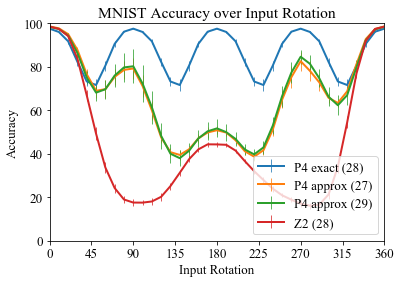

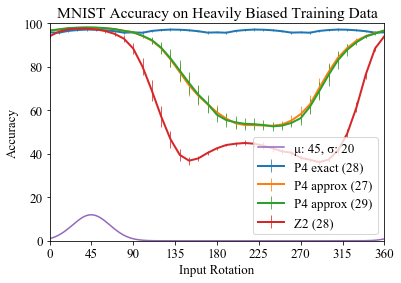

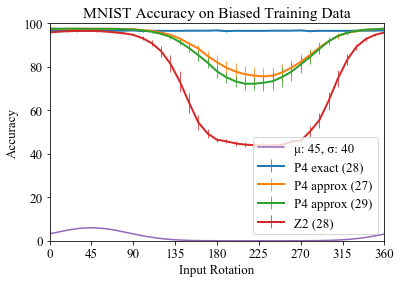

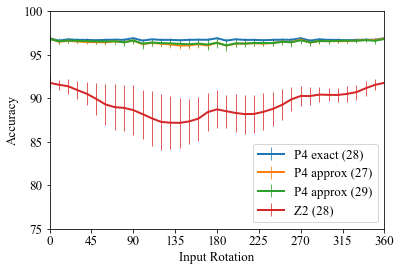

In [6]:
'''
Slurm folder: ./TC_slurms
'''

show_results('./training_output/cohen_no_bias.out',
             names=['P4 exact (28)', 'P4 approx (27)', 'P4 approx (29)', 'Z2 (28)'],
             names_file=['P4 exact (28)', 'P4 approx (27)', 'P4 approx (29)', 'Z2 (28)'],
             repeats=10, show_avg=False, save='./final_no_bias.PNG', xmax=360, title='MNIST Accuracy over Input Rotation')

show_results('./training_output/cohen_20.out', norm_dist=True, norm_mu=45, norm_sigma=20,
             names=['P4 exact (28)', 'P4 approx (27)', 'P4 approx (29)', 'Z2 (28)'],
             names_file=['P4 exact (28)', 'P4 approx (27)', 'P4 approx (29)', 'Z2 (28)'],
             repeats=10, show_avg=False, save='./final_bias_20.PNG', xmax=360, title='MNIST Accuracy on Heavily Biased Training Data')

show_results('./training_output/cohen_40.out', norm_dist=True, norm_mu=45, norm_sigma=40,
             names=['P4 exact (28)', 'P4 approx (27)', 'P4 approx (29)', 'Z2 (28)'],
             names_file=['P4 exact (28)', 'P4 approx (27)', 'P4 approx (29)', 'Z2 (28)'],
             repeats=10, show_avg=False, save='./final_bias_40.PNG', xmax=360, title='MNIST Accuracy on Biased Training Data')

show_results('./training_output/cohen_uniform.out', ymin=75,
             names=['P4 exact (28)', 'P4 approx (27)', 'P4 approx (29)', 'Z2 (28)'],
             names_file=['P4 exact (28)', 'P4 approx (27)', 'P4 approx (29)', 'Z2 (28)'],
             repeats=10, show_avg=False, save='./final_uniform_bias.PNG', xmax=360)


In [8]:
import scipy.stats as stats

files = ['./training_output/cohen_no_bias.out', './training_output/cohen_uniform.out']
models = ['P4 exact (28)', 'P4 aprox (27)', 'P4 aprox (29)', 'Z2 (28)']#, 'cnn big', '4xcnn', '4xcnn pooled']

def get_0_acc(x, model):
    accs = []
    for d in x[model]:
        accs.append(d[0])
    return np.mean(accs), np.std(accs), accs

def get_avg_acc(x, model):
    accs = []
    for d in x[model]:
        accs.append(np.mean(list(d.values())))
    return np.mean(accs), np.std(accs), accs

for file in files:
    print('\n')
    print(file)
    accuracies = {}
    x = read_slurm(file, names=models, repeats=10)
    for model in models:
        if 'uni' in file:
            acc, std, accs = get_avg_acc(x, model)
        else:
            acc, std, accs = get_0_acc(x, model)
        accuracies[model] = accs
        print('Model {:}: ${:.2f} \pm {:.2f}$ [{:}]'.format(model, acc, std, 
                                                           stats.t.interval(alpha=0.95, df=len(accs)-1, loc=np.mean(accs), scale=stats.sem(accs)) ))
        #print(f'Model {model}: {acc}, {std}')
    print('---')
    for m1 in models:
        for m2 in models:
            if m1 == m2:
                continue
            print('{:}:{:} => p={:.5f}'.format(m1,m2,stats.ttest_ind(a=accuracies[m1], b=accuracies[m2], equal_var=False).pvalue))



./training_output/cohen_no_bias.out
Model P4 exact (28): $97.56 \pm 0.18$ [(97.4230916324658, 97.69957377280764)]
Model P4 aprox (27): $98.61 \pm 0.07$ [(98.55396669191657, 98.66240293698968)]
Model P4 aprox (29): $98.39 \pm 0.35$ [(98.13203671406917, 98.6526007371027)]
Model Z2 (28): $98.50 \pm 0.17$ [(98.37164214204438, 98.62204071928375)]
---
P4 exact (28):P4 aprox (27) => p=0.00000
P4 exact (28):P4 aprox (29) => p=0.00002
P4 exact (28):Z2 (28) => p=0.00000
P4 aprox (27):P4 exact (28) => p=0.00000
P4 aprox (27):P4 aprox (29) => p=0.09679
P4 aprox (27):Z2 (28) => p=0.08915
P4 aprox (29):P4 exact (28) => p=0.00002
P4 aprox (29):P4 aprox (27) => p=0.09679
P4 aprox (29):Z2 (28) => p=0.42780
Z2 (28):P4 exact (28) => p=0.00000
Z2 (28):P4 aprox (27) => p=0.08915
Z2 (28):P4 aprox (29) => p=0.42780


./training_output/cohen_uniform.out
Model P4 exact (28): $96.74 \pm 0.12$ [(96.65132664989751, 96.82760096240717)]
Model P4 aprox (27): $96.43 \pm 0.27$ [(96.23502102630304, 96.63469943268133)

In [10]:
import scipy.stats as stats

files = [('./training_output/cohen_no_bias.out', './training_output/statistical_1.out', './training_output/statistical_2.out', './training_output/statistical_3.out'),
         ('./training_output/cohen_uniform.out', './training_output/statistical_uni_1.out', './training_output/statistical_uni_2.out', './training_output/statistical_uni_3.out')]
models = ['P4 exact (28)', 'P4 aprox (27)', 'P4 aprox (29)', 'Z2 (28)']#, 'cnn big', '4xcnn', '4xcnn pooled']

def get_0_acc(x, model):
    accs = []
    for d in x[model]:
        accs.append(d[0])
    return np.mean(accs), np.std(accs), accs

def get_avg_acc(x, model):
    accs = []
    for d in x[model]:
        accs.append(np.mean(list(d.values())))
    return np.mean(accs), np.std(accs), accs

for file in files:
    print('\n')
    print(file)
    accuracies = {}
    x = read_slurm(file[0], names=models, repeats=10)
    for f in range(1, len(file)):
        y = read_slurm(file[f], names=models, repeats=30)
        x = combine_slurms(x, y)
    for model in models:
        if 'uni' in file:
            acc, std, accs = get_avg_acc(x, model)
        else:
            acc, std, accs = get_0_acc(x, model)
        accuracies[model] = accs
        print('Model {:}: ${:.2f} \pm {:.2f}$ [{:}]'.format(model, acc, std, 
                                                           stats.t.interval(alpha=0.95, df=len(accs)-1, loc=np.mean(accs), scale=stats.sem(accs)) ))
        #print(f'Model {model}: {acc}, {std}')
    print('---')
    for m1 in models:
        for m2 in models:
            if m1 == m2:
                continue
            print('{:}:{:} => p={:}'.format(m1,m2,stats.ttest_ind(a=accuracies[m1], b=accuracies[m2]).pvalue, equal_var=False))
#            print('{:}:{:} => p={:}'.format(m1,m2,stats.mannwhitneyu(x=accuracies[m1], y=accuracies[m2]).pvalue))



('./training_output/cohen_no_bias.out', './training_output/statistical_1.out', './training_output/statistical_2.out', './training_output/statistical_3.out')
Model P4 exact (28): $97.69 \pm 0.17$ [(97.65676179433918, 97.72432646249676)]
Model P4 aprox (27): $98.52 \pm 0.26$ [(98.4674428975232, 98.57079562786743)]
Model P4 aprox (29): $98.42 \pm 0.25$ [(98.37454911949928, 98.47483137366478)]
Model Z2 (28): $98.47 \pm 0.17$ [(98.44019680100702, 98.5068552009461)]
---
P4 exact (28):P4 aprox (27) => p=2.3260841350427014e-67
P4 exact (28):P4 aprox (29) => p=8.925949766720978e-61
P4 exact (28):Z2 (28) => p=7.77819017398157e-82
P4 aprox (27):P4 exact (28) => p=2.3260841350427014e-67
P4 aprox (27):P4 aprox (29) => p=0.009963561545412652
P4 aprox (27):Z2 (28) => p=0.1428258660108
P4 aprox (29):P4 exact (28) => p=8.925949766720978e-61
P4 aprox (29):P4 aprox (27) => p=0.009963561545412652
P4 aprox (29):Z2 (28) => p=0.1091132129630101
Z2 (28):P4 exact (28) => p=7.77819017398157e-82
Z2 (28):P4 apr